In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import datetime
# plt.rcParams['axes.facecolor'] = 'white'

import warnings
warnings.filterwarnings('ignore')

In [2]:
root_path = '~/deepdow_poc'
raw_data = root_path + '/raw_data/'

In [3]:
"""
We will load the dataset for each assets, filter only the adj close column to use as our feature and concat the assets into same dataframe
"""

def load_prepare_data(assets_list, suffix, col=['Adj Close']): #, 'Volume']):
    assets_dict = {}
    temp_list = []
    
    if suffix != None:
        for asset in assets_list:
            df_temp = pd.read_csv(raw_data + asset + suffix +'.csv')
            df_temp['Date'] = pd.to_datetime(df_temp['Date'])
            df_temp.set_index('Date', inplace=True)
            df_temp = pd.DataFrame(df_temp[col])

            assets_dict[asset] = df_temp
            temp_list.append(df_temp)
    else:
        for asset in assets_list:
            df_temp = pd.read_csv(raw_data + asset +'.csv')
            df_temp['Date'] = pd.to_datetime(df_temp['Date'])
            df_temp.set_index('Date', inplace=True)
            df_temp = pd.DataFrame(df_temp[col])

            assets_dict[asset] = df_temp
            temp_list.append(df_temp)
            
    df = pd.concat(temp_list, keys=assets_list, axis=1)
    return assets_dict, df


ASSETS = ['AAPL', 'TSLA', 'SHOP', 'HLFNX','VGT']
_,df_1 = load_prepare_data(ASSETS, '_train')
_,df_2 = load_prepare_data(ASSETS, '_test')
df = pd.concat([df_1, df_2], axis=0)

In [4]:
"""
Convert the data of the asset price to daily returns
"""

def to_return(data, col, log=True):
    df = data.copy()
    for asset in df.columns.levels[0]:
        if log:
            df[asset, 'Adj Close'] = df[asset, 'Adj Close'].pct_change().apply(lambda x: np.log(1+x))
        else:
            df[asset, 'Adj Close'] = df[asset, 'Adj Close'].pct_change()
            
    return df.iloc[1:]

df_1 = to_return(df_1, 'Adj Close')
df_2 = to_return(df_2, 'Adj Close')
df = to_return(df, 'Adj Close')

In [5]:
df

,AAPL,TSLA,SHOP,HLFNX,VGT
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
Date,,,,,
2019-01-03,-0.104924,-0.031978,-0.058433,-0.020795,-0.050685
2019-01-04,0.041803,0.056094,0.061771,0.035463,0.042565
2019-01-07,-0.002228,0.052935,0.044830,0.006221,0.011111
2019-01-08,0.018884,0.001164,0.007246,0.003096,0.009570
2019-01-09,0.016839,0.009438,0.021629,0.008209,0.012405
...,...,...,...,...,...
2020-12-23,-0.007000,0.008769,-0.063956,0.002863,-0.009144
2020-12-24,0.007683,0.024150,0.022745,0.004635,0.006625


In [6]:
"""
Establish constants
1. Rebalance freq = BMS first business day of month
2. Lookback = number of historical data in unit of days that 
   deep learning use to learn to predict weight for the horizon
3. Horizon = days that user hold before rebalance. Corresponds to the Rebalance freq. 
    20 days = n_business_day in 1 month
"""

LOOKBACK = 40
HORIZON = 20
WINDOW = 250
N_SAMPLES = WINDOW - LOOKBACK - HORIZON
N_ASSETS = len(df.columns.levels[0])
N_FEATURES = LOOKBACK * N_ASSETS

"""
first day of the month in the historical data
go through each element in list, if month changes, that is the first day of month, assuming time is ordered in the list
"""
def get_first_date(datelist):
    rebal_dates = []
    for index,d in enumerate(df.index):
        if index==0:
            rebal_dates.append(d)
            current_month = d.month
        else:
            if d.month != current_month:
                rebal_dates.append(d)
                current_month = d.month
            else:
                continue
    return rebal_dates

REBAL_DATES = get_first_date(df.index)


In [7]:
"""
Train and optimize.
Training and optimize will be done to 1 rolling window to predict the weight to use for the horizon.
Rolling window will start from T(rebalance date) and go backwards
"""

# first will define the loss functions
import tensorflow as tf

def portfolio_returns(weights, y):
    """
    Input
    --------
    weights = the predicted values output from neural network. (n_samples, n_asset)
    y = test data (n_samples, horizon, n_asset) use for loss calculation
    """
    # exp to reverse log transform
    y = tf.math.exp(y) - 1
    n_samples = tf.shape(y)[0]
    horizon = tf.shape(y)[1]
    n_assets = tf.shape(y)[2]
    
    """ 
    reshape the weight into (n_samples, horizon, n_asset) dimension
    first we have (n_samples, n_assets) weight output from neural network output
    we want to repeat the vector horizon amount of time
    """
    weights_ = tf.tile(tf.reshape(weights, [n_samples, 1, n_assets]), (1, horizon, 1))
    
    """
    rebalance : now will always be false (same for all time steps in the horizon)
        If True, each timestep the weights are adjusted to be equal to be equal to the original ones. Note that
        this assumes that we tinker with the portfolio. If False, the portfolio evolves untouched.
    """
    rebalance=False
    
    if not rebalance:
        weights_unscaled = tf.math.cumprod((1 + y),1)[:, :-1, :] * weights_[:, 1:, :]
        
        output_list = []
        output_list.append(weights_[:, 0, :])
        
        remaining = weights_unscaled / tf.math.reduce_sum(weights_unscaled, 2, keepdims=True)
        rows = remaining.get_shape()
        for row in range(rows[1]):
            output_list.append(remaining[:, row,:])
        
        new_weights = tf.stack(output_list, axis=1)

    out = tf.math.reduce_sum((y * new_weights),-1)
    
    # shape (n_samples, horizon) representing per timestep portfolio returns
    return out

def MeanReturns(y, weights):#, rebalance=False):
    """Negative mean returns"""
    prets = portfolio_returns(weights, y[:, 0, ...])#, rebalance=rebalance)
    
    """Tensor of shape `(n_samples,)` representing the per sample negative mean returns."""
    # neg_mean = tf.math.exp(prets)
    mean = tf.math.reduce_mean(prets, 1)
    neg_mean = mean * -1
    return neg_mean

def SharpeRatio(y, weights, rf=0.01, eps=1e-4):
    """Negative Sharpe ratio"""
    prets = portfolio_returns(weights, y[:, 0, ...])#, rebalance=rebalance)
    
    """Tensor of shape `(n_samples,)` representing the per sample negative mean returns."""
    sharpe = ((tf.math.reduce_mean(prets, 1) - rf)/(tf.math.reduce_std(prets, 1) + eps))
    neg_sharpe = sharpe * -1
    return neg_sharpe

def LargestWeight(y, weights):
    """Penalize low diversity, or over powering weight in 1 asset, lower = better"""
    return tf.reduce_max(weights, 1)[0]

def StandardDeviation(y, weights):
    """Returns std dev of portfolio return of the horizon, lower = better"""
    prets = portfolio_returns(weights, y[:, 0, ...])
    return tf.math.reduce_std(prets, 1)

def make_my_loss(alpha):
    def my_loss(y, weights):
        """Combination of different loss functions for the final loss calculation"""
        return (alpha[0] * MeanReturns(y, weights)
                + alpha[1] * SharpeRatio(y, weights)
                + alpha[2] * StandardDeviation(y, weights)
               )
    return my_loss


In [8]:
"""
Define the model archtecture
-----------------------------
This is a simple feedfoward model that the input is the flattened array of (n_samples, n_features)
n_features = n_assets * horizon

The output is softmax of dimension n_assets. Softmax --> sum of all weight = 1
"""
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.activations import softmax

def build_model(n_assets, input_shape, dropout):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = Dropout(dropout)(x)
    weights = Dense(n_assets, activation="linear")(x)
    outputs = Softmax()(weights)

    return keras.Model(inputs, outputs)

In [9]:
"""
Train and predict
1. Get the rolling window data from of T-250
2. scale and split data to prepare for neural network input, Xtrain, Xtest, ytrain, ytest, Xpred
3. Train the model with Xtrain,Xtest,ytrain,ytest
4. Predict weight using Xpred
5. Save weight for that T
6. Repeat 1 - 5 for every T(rebal date)
"""
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=50, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
N_EPOCHS = 1000
BATCH_SIZE = 32

# we will start the prediction from year 2020
pred_dates = [d for d in REBAL_DATES if d.year == 2020]

def get_window(df,pred_date):
    temp = df.copy()
    pred_date_ind = np.where(temp.index == pred_date)[0][0]
    window = temp.iloc[((pred_date_ind+1)-WINDOW):(pred_date_ind+1)]
    return window

def create_input(df):
    data = df.copy()
    scaler = MinMaxScaler(feature_range=(0,1))
    transformer = scaler.fit(data)
    scaled_data = pd.DataFrame(transformer.transform(data), columns=data.columns)
    test_data = scaled_data.iloc[:100]
    train_data = scaled_data.iloc[100:]
    
    n_test_sample = 100 - LOOKBACK - HORIZON
    n_train_sample = 100 - LOOKBACK - HORIZON
    
    assets = scaled_data.columns.levels[0].tolist()
    channels = scaled_data.columns.levels[1].tolist()
    
    n_channels = len(data.columns.levels[1])
    channel = scaled_data.columns.levels[1][0]
    for index, asset in enumerate(assets):
        if (index == 0):
            test_temp = test_data[asset, channel].values.reshape(-1,1)
            train_temp = train_data[asset, channel].values.reshape(-1,1)
            full_temp = scaled_data[asset, channel].values.reshape(-1,1)
        else:
            test_temp = np.concatenate((test_temp, test_data[asset, channel].values.reshape(-1,1)), axis=1)
            train_temp = np.concatenate((train_temp, train_data[asset, channel].values.reshape(-1,1)), axis=1)
            full_temp = np.concatenate((full_temp, scaled_data[asset, channel].values.reshape(-1,1)), axis=1)
            
    data_block_test = test_temp.reshape(n_channels,test_temp.shape[0],test_temp.shape[1])
    data_block_train = train_temp.reshape(n_channels,train_temp.shape[0],train_temp.shape[1])
    data_block = full_temp.reshape(n_channels,full_temp.shape[0],full_temp.shape[1])
    
    X_train, X_test, y_train, y_test, X_pred = [], [], [], [], []
    
    for i in range(n_train_sample):
        X_train.append(data_block_train[:,i:(i+LOOKBACK),:])
        y_train.append(data_block_train[:,(i+LOOKBACK):(i + LOOKBACK + HORIZON),:])
        
    for i in range(n_train_sample):
        X_test.append(data_block_test[:,i:(i+LOOKBACK),:])
        y_test.append(data_block_test[:,(i+LOOKBACK):(i + LOOKBACK + HORIZON),:])
        
    X_pred.append(data_block_test[:,-LOOKBACK:,:])
        
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_pred)

"""Here will start train and predict rolling window, getting weight for each rebalance date"""
portfolio_weights = []
for d in pred_dates:
    data = get_window(df, d)
    
    # split 100 sample for train, 100 sample for test. Since we have 190 samples, some test data will overlap
    X_train, y_train, X_test, y_test, X_pred = create_input(data)
    print(f"X_train shape = {X_train.shape}")
    print(f"y_train shape = {y_train.shape}")
    print(f"X_test shape = {X_test.shape}")
    print(f"y_test shape = {y_test.shape}")
    print(f"X_pred shape = {X_pred.shape}")
    
    model = build_model(
    n_assets=N_ASSETS,
    input_shape = (N_FEATURES),
    dropout=0.5
    )

    my_loss = make_my_loss([0.1, 0.2, 0.7])
    model.compile(
        loss= my_loss,
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    )
    model.summary()
    
    X_train_in = X_train.reshape(X_train.shape[0], -1)
    X_test_in = X_test.reshape(X_test.shape[0], -1)
    
    history = model.fit(
        X_train_in,
        y_train,
        validation_data=(X_test_in, y_test),
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es]
        )
    
    X_pred_in = X_pred.reshape(X_pred.shape[0], -1)
    weights = model.predict(X_pred_in)
    portfolio_weights.append(weights)

X_train shape = (40, 1, 40, 5)
y_train shape = (40, 1, 20, 5)
X_test shape = (40, 1, 40, 5)
y_test shape = (40, 1, 20, 5)
X_pred shape = (1, 1, 40, 5)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0
_________________________________________________________________


2021-10-03 15:45:20.684171: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-10-03 15:45:20.825124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
2/2 [==============================] - 3s 539ms/step - loss: -0.7719 - val_loss: -1.0597
Epoch 2/1000
2/2 [==============================] - 0s 53ms/step - loss: -0.7482 - val_loss: -1.0601
Epoch 3/1000
2/2 [==============================] - 0s 59ms/step - loss: -0.7679 - val_loss: -1.0605
Epoch 4/1000
2/2 [==============================] - 0s 52ms/step - loss: -0.7860 - val_loss: -1.0609
Epoch 5/1000
2/2 [==============================] - 0s 54ms/step - loss: -0.7718 - val_loss: -1.0613
Epoch 6/1000
2/2 [==============================] - 0s 52ms/step - loss: -0.7660 - val_loss: -1.0617
Epoch 7/1000
2/2 [==============================] - 0s 56ms/step - loss: -0.7744 - val_loss: -1.0621
Epoch 8/1000
2/2 [==============================] - 0s 55ms/step - loss: -0.7714 - val_loss: -1.0624
Epoch 9/1000
2/2 [==============================] - 0s 61ms/step - loss: -0.7962 - val_loss: -1.0626
Epoch 10/1000
2/2 [==============================] - 0s 57ms/step - loss: -0.7816 - val_lo

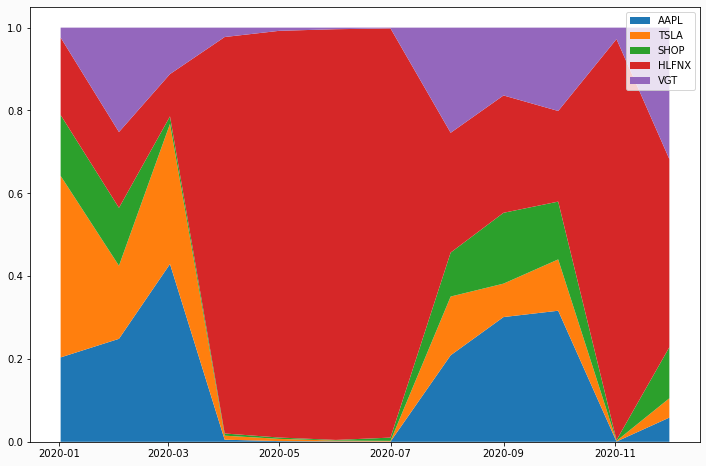

In [10]:
portfolio_weights = np.array(portfolio_weights)
portfolio_weights = portfolio_weights.flatten().reshape(len(pred_dates),-1)
weights_df = pd.DataFrame(portfolio_weights, columns=ASSETS, index=pred_dates)

background_color = '#fbfbfb'
fig = plt.figure(figsize=(12, 8), facecolor=background_color)
stack_list = []
for asset in ASSETS:
    stack_list.append(weights_df[asset])
        
plt.stackplot(weights_df.index, stack_list, labels=ASSETS)
plt.legend(loc='upper right')
plt.show()

In [24]:
"""
Baseline model best weights per month based on weights that give the best Sharpe ratio
"""

def get_rand_weights(n_samples, n_assets):
    port_weights = []
  
    for port in range(n_samples):
        weights = np.random.random(n_assets)
        weights = weights/np.sum(weights)
        port_weights.append(weights)
  
    return port_weights

def weights_best_sharpe(random_port_weights, unweighted_rets, data, rebal_date, rf=0.01):
    indv_return = unweighted_rets
    port_returns = []
    port_volatility = []
    df_dict = {}

    for weights in random_port_weights:
        # calculate the port return for that random weight
        port_expr = indv_return.dot(weights)
        port_returns.append(port_expr)

        # calculate the monthly volatility
        covariance = data.cov()
        var = np.transpose(weights)@covariance@weights
        sd = np.sqrt(var)
        monthly_sd = sd*np.sqrt(HORIZON)
        port_volatility.append(monthly_sd)

    df_dict['returns'] = port_returns
    df_dict['volatility'] = port_volatility
    ret_vol = pd.DataFrame(df_dict)
    monthly_weight = pd.DataFrame(random_port_weights, columns=ASSETS)
    final_df = pd.concat([ret_vol,monthly_weight], axis=1)
    
      # find row with best sharpe ratio
    optimal_portfolio = final_df.iloc[((final_df['returns'] - rf)/final_df['volatility']).idxmax()]
    return np.array(optimal_portfolio)

num_portfolios = 10000

_,df_3 = load_prepare_data(ASSETS, '_train')
_,df_4 = load_prepare_data(ASSETS, '_test')
df_bl = pd.concat([df_1, df_2], axis=0)
pred_dates = [d for d in REBAL_DATES if d.year == 2020]

bl_weights = np.array([])
for d in pred_dates:
    data = get_window(df_bl, d)
    returns = to_return(data, 'Adj Close')
    
    #calculate the unweighted individual return for past 250 days
    first_last = pd.concat([pd.DataFrame(data.iloc[0]).T, pd.DataFrame(data.iloc[-1]).T])
    indv_rets = first_last.pct_change().apply(lambda x: np.log(1+x)).mean().values
    
    random_port_weights = get_rand_weights(num_portfolios, N_ASSETS)
    
    bl_weights = np.append(bl_weights, weights_best_sharpe(random_port_weights, indv_rets, data, d, rf=0.01))

# contruct dataframe with weights, and use pred_dates and index
bl_weights_df = pd.DataFrame(bl_weights.reshape(-1, N_ASSETS + 2)[:,-N_ASSETS:], index=pred_dates, columns = ASSETS)

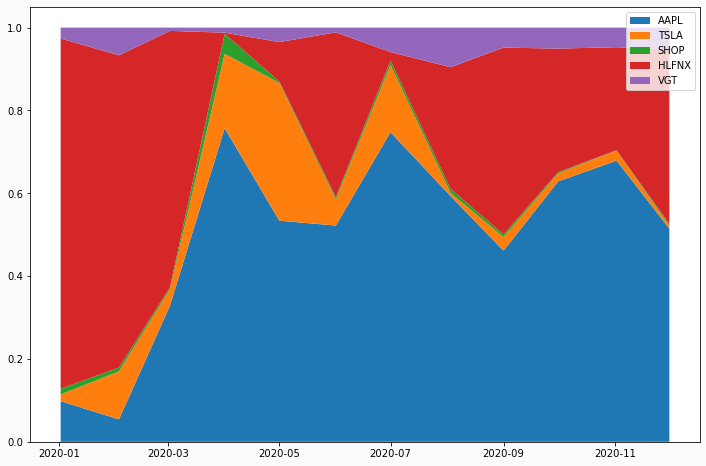

In [25]:
background_color = '#fbfbfb'
fig = plt.figure(figsize=(12, 8), facecolor=background_color)
stack_list = []
for asset in ASSETS:
    stack_list.append(bl_weights_df[asset])
        
plt.stackplot(bl_weights_df.index, stack_list, labels=ASSETS)
plt.legend(loc='upper right')
plt.show()

In [56]:
"""
We will see what the volatility and return the weights predicted/optimized using the data from T-250 will do to horizon, in this case T + 20.
"""

# create dataframe of unweighted price change (expected return) of each rebalance date
_,df_1 = load_prepare_data(ASSETS, '_train')
_,df_2 = load_prepare_data(ASSETS, '_test')
df_price = pd.concat([df_1, df_2], axis=0)
pred_dates = [d for d in REBAL_DATES if d.year == 2020]

def result_new_weight(price_data, weights, rebal_dates):
    
    monthly_price = price_data.loc[rebal_dates]
    monthly_return = monthly_price.pct_change().apply(lambda x: np.log(1+x)).iloc[1:]
    
    all_port_expr = []
    all_port_volatility = []
    df_dict = {}
    
    for index,d in enumerate(rebal_dates[1:]):
        #calculate returns 
        port_expr = monthly_return.iloc[index].values.dot(weights.iloc[index].values)
        all_port_expr.append(port_expr)
        
        #calculate returns
        data = get_window(price_data, d)
        data = to_return(data, 'Adj Close')
        covariance = data.cov()
        var = np.transpose(weights.iloc[index].values)@covariance@weights.iloc[index].values
        sd = np.sqrt(var)
        monthly_sd = sd*np.sqrt(HORIZON)
        all_port_volatility.append(monthly_sd)
    
    df_dict['returns'] = all_port_expr
    df_dict['volatility'] = all_port_volatility
    ret_vol = pd.DataFrame(df_dict, index = rebal_dates[1:])
    # monthly_weight = pd.DataFrame(random_port_weights, columns=ASSETS)
    final_df = pd.concat([ret_vol,weights], axis=1)
    return final_df

def shift_month(original, shift=1):
    temp = original.copy()
    temp = temp.iloc[:-shift].set_index(temp.index[shift:])
    return temp
    
result_df = result_new_weight(df_price, shift_month(weights_df), pred_dates)
result_df_bl = result_new_weight(df_price, shift_month(bl_weights_df), pred_dates)

In [57]:
result_df

,returns,volatility,AAPL,TSLA,SHOP,HLFNX,VGT
2020-02-03,0.291919,0.080871,0.203771,0.438399,0.146856,0.187004,0.023970
2020-03-02,-0.029858,0.068890,0.248671,0.176389,0.139907,0.182989,0.252044
2020-04-01,-0.301549,0.121339,0.429298,0.338358,0.018036,0.102192,0.112116
2020-05-01,0.164455,0.114460,0.005087,0.009700,0.005325,0.957224,0.022665
2020-06-01,0.104308,0.116641,0.001677,0.005411,0.003176,0.982053,0.007683
2020-07-01,0.006679,0.121150,0.000966,0.001894,0.001623,0.991701,0.003816
2020-08-03,0.043302,0.121269,0.000610,0.001634,0.007881,0.988028,0.001847
2020-09-01,0.160940,0.116335,0.208952,0.141779,0.106184,0.289205,0.253880
2020-10-01,-0.075296,0.119796,0.301190,0.080692,0.171049,0.283321,0.163749
2020-11-02,-0.080543,0.123345,0.316481,0.123873,0.139584,0.218862,0.201199


In [58]:
result_df_bl

,returns,volatility,AAPL,TSLA,SHOP,HLFNX,VGT
2020-02-03,0.033806,0.042997,0.098067,0.016173,0.013906,0.845606,0.026248
2020-03-02,-0.051236,0.054190,0.054120,0.115982,0.009176,0.753806,0.066918
2020-04-01,-0.303435,0.103897,0.328975,0.039445,0.004643,0.619050,0.007887
2020-05-01,0.230224,0.119212,0.757229,0.179502,0.047918,0.003156,0.012194
2020-06-01,0.155376,0.126029,0.533819,0.332624,0.003535,0.095185,0.034836
2020-07-01,0.082930,0.112662,0.522148,0.063010,0.005733,0.397675,0.011434
2020-08-03,0.186332,0.119481,0.747673,0.162423,0.010697,0.020189,0.059018
2020-09-01,0.157729,0.111772,0.592969,0.007614,0.009640,0.294199,0.095578
2020-10-01,-0.079423,0.115913,0.461593,0.032535,0.006588,0.451081,0.048204
2020-11-02,-0.068269,0.119924,0.628763,0.019374,0.002936,0.298304,0.050624
